Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [3]:
# Load preprocessed data for DNN
fetched_data = np.zeros([11307, 19728])
labels = np.zeros(11307)
data_index = 0

for actor in ACTORS:
  file_path = FILE_PATH + actor + '/'
  print(file_path)
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'

      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)
        # 4624
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data).flatten()
        #15104
      for i in range(video.shape[0]):
        fetched_data[data_index] = np.concatenate([video[i], audio])
        labels[data_index] = np.array(int(CURRENT_FILE[7])-1)
        data_index += 1

/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_01/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_02/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_03/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_04/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_05/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_06/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_07/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_08/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_09/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_10/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_11/
/content/drive/MyDrive/CV_Project_Workspace

In [4]:
print(fetched_data[-1])

[  0.          18.02775638  35.35533906 ... -80.         -80.
 -80.        ]


In [5]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.1 * example_nums)
validation_example_nums = example_nums - train_example_nums - test_example_nums

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:train_example_nums+test_example_nums]
random_validation_ids = random_ids[train_example_nums+test_example_nums:]

print(len(random_train_ids), len(random_test_ids), len(random_validation_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:])
Y_train = torch.as_tensor(labels[random_train_ids]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:])
Y_test = torch.as_tensor(labels[random_test_ids]).type(torch.int64)

X_vali = torch.as_tensor(fetched_data[random_validation_ids,:])
Y_vali = torch.as_tensor(labels[random_validation_ids]).type(torch.int64)


9045 1130 1132


In [6]:
X_vali

tensor([[  0.0000,  16.1245,  32.3883,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  18.1108,  36.3456,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  17.0294,  33.2415,  ..., -80.0000, -80.0000, -80.0000],
        ...,
        [  0.0000,  18.1108,  35.6931,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  18.1108,  35.3553,  ..., -80.0000, -80.0000, -80.0000],
        [  0.0000,  15.8114,  31.9531,  ..., -79.9921, -79.9921, -79.9921]],
       dtype=torch.float64)

In [7]:
Y_vali

tensor([0, 2, 1,  ..., 4, 4, 1])

In [8]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [9]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)
validation_dataset = Dataset(X_vali, Y_vali)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([6, 6, 1,  ..., 4, 1, 2])


In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        out = self(features.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch
        out = self(features.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [17]:
class DNN_Video(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(4624, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

class DNN_Audio(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(15104, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

In [86]:
class LR_Perceptron(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.model_video = DNN_Video()
    self.model_video.to(device)
    self.model_audio = DNN_Audio()
    self.model_audio.to(device)
    self.model_video.load_state_dict(torch.load('/content/drive/MyDrive/CV_Project_Workspace/Project_Code/late_fusion_DNN/video.pth'))
    self.model_audio.load_state_dict(torch.load('/content/drive/MyDrive/CV_Project_Workspace/Project_Code/late_fusion_DNN/audio.pth'))
    self.fc1 = torch.nn.Linear(16, 80)
    self.fc2 = torch.nn.Linear(80, 80)
    self.fc3 = torch.nn.Linear(80, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    v = self.model_video(x[:,:4624])
    a = self.model_audio(x[:,4624:])
    x = self.fc1(torch.cat((v,a), dim=1))
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [106]:
model = LR_Perceptron()
model.to(device)
# train_dataset.labels = train_dataset.labels.to(device)
# train_dataset.faces = train_dataset.faces.to(device)
# test_dataset.labels = test_dataset.labels.to(device)
# test_dataset.faces = test_dataset.faces.to(device)
# validation_dataset.labels = validation_dataset.labels.to(device)
# validation_dataset.faces = validation_dataset.faces.to(device)

LR_Perceptron(
  (model_video): DNN_Video(
    (fc1): Linear(in_features=4624, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=512, bias=True)
    (fc5): Linear(in_features=512, out_features=512, bias=True)
    (fc6): Linear(in_features=512, out_features=8, bias=True)
  )
  (model_audio): DNN_Audio(
    (fc1): Linear(in_features=15104, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=512, bias=True)
    (fc5): Linear(in_features=512, out_features=512, bias=True)
    (fc6): Linear(in_features=512, out_features=8, bias=True)
  )
  (fc1): Linear(in_features=16, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (fc3): Linear(in_features=80, ou

In [20]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size*4)

In [107]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.110813856124878, 'val_acc': 0.14200745522975922}]

In [108]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 1.0757, val_acc: 0.6132
Epoch [1], val_loss: 0.6082, val_acc: 0.8147
Epoch [2], val_loss: 0.5979, val_acc: 0.7867
Epoch [3], val_loss: 0.4985, val_acc: 0.8191
Epoch [4], val_loss: 0.7296, val_acc: 0.7149
Epoch [5], val_loss: 0.2879, val_acc: 0.9039
Epoch [6], val_loss: 0.3044, val_acc: 0.9045
Epoch [7], val_loss: 0.2710, val_acc: 0.9154
Epoch [8], val_loss: 0.2082, val_acc: 0.9389
Epoch [9], val_loss: 0.1792, val_acc: 0.9438
Epoch [10], val_loss: 0.4649, val_acc: 0.8224
Epoch [11], val_loss: 0.1697, val_acc: 0.9425
Epoch [12], val_loss: 0.3493, val_acc: 0.8597
Epoch [13], val_loss: 0.3934, val_acc: 0.8533
Epoch [14], val_loss: 0.1080, val_acc: 0.9684
Epoch [15], val_loss: 0.2890, val_acc: 0.8902
Epoch [16], val_loss: 0.1090, val_acc: 0.9743
Epoch [17], val_loss: 0.2069, val_acc: 0.9251
Epoch [18], val_loss: 0.3258, val_acc: 0.8905
Epoch [19], val_loss: 0.1055, val_acc: 0.9674


In [109]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 0.1961, val_acc: 0.9324
Epoch [1], val_loss: 0.0846, val_acc: 0.9738
Epoch [2], val_loss: 0.3374, val_acc: 0.8802
Epoch [3], val_loss: 0.1051, val_acc: 0.9697
Epoch [4], val_loss: 0.0409, val_acc: 0.9948
Epoch [5], val_loss: 0.1199, val_acc: 0.9617
Epoch [6], val_loss: 0.0547, val_acc: 0.9832
Epoch [7], val_loss: 0.0755, val_acc: 0.9818
Epoch [8], val_loss: 0.1317, val_acc: 0.9473
Epoch [9], val_loss: 0.0386, val_acc: 0.9870
Epoch [10], val_loss: 0.4413, val_acc: 0.8323
Epoch [11], val_loss: 0.1014, val_acc: 0.9693
Epoch [12], val_loss: 0.0266, val_acc: 0.9948
Epoch [13], val_loss: 0.0221, val_acc: 0.9965
Epoch [14], val_loss: 0.0333, val_acc: 0.9913
Epoch [15], val_loss: 0.0129, val_acc: 0.9983
Epoch [16], val_loss: 0.0101, val_acc: 0.9991
Epoch [17], val_loss: 0.0812, val_acc: 0.9773
Epoch [18], val_loss: 0.2409, val_acc: 0.9162
Epoch [19], val_loss: 0.3470, val_acc: 0.8632


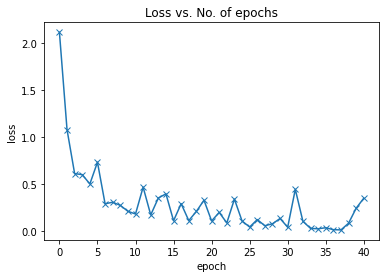

In [110]:
plot_losses(history)

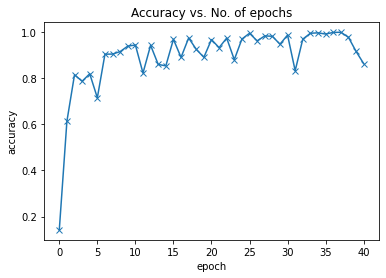

In [111]:
plot_accuracies(history)

In [112]:
evaluate(model, test_dataloader)

{'val_loss': 0.3535049259662628, 'val_acc': 0.865205705165863}

In [113]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/emotion_classification-feedforward.pth")